<a href="https://colab.research.google.com/github/turna1/Computer-Vision/blob/main/Non_invasive_Anemia_Detection_from_Conjunctival_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anemia is a worldwide health issue. To diagnose anemia, blood must be drawn to examine the hemoglobin level. The procedure is time-consuming and labor-intensive. The existing Artificial Intelligence (AI)-based anemia detection methods in literature have shortcomings, including, i) specially designed data collection device, ii) manual feature extraction, iii) small data size for training the model, and iv)user’s trust in AI prediction. In this paper, we aim to provide a non-invasive model of anemia detection from visible signs. We trained a CNN model on eye-membrane image data collected from real patients and open image sources. Our model predicts anemic patients with good accuracy at 98%. In addition, we proposed the explainable AI method as a part of the non-invasive diagnosis to enhance the user’s trust in the CNN model’s prediction.
Paper Link: https://link.springer.com/chapter/10.1007/978-3-031-22061-6_14

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

Define parameters


In [ ]:
BATCH_SIZE_1 = 16
IMAGE_SIZE_1 = 128
BATCH_SIZE_2 = 32
IMAGE_SIZE_2 = 256
CHANNELS=3
EPOCHS=50

Import Dataset


In [ ]:
from zipfile import ZipFile
file_name = '/content/images.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Create Tensorflow data pipeline

In [ ]:
images_ds = tf.data.Dataset.list_files('images/*/*', shuffle=True)

For parameter set-1

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE_1,IMAGE_SIZE_1),
    batch_size=BATCH_SIZE_1
)

Found 183 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['anemic', 'non-anemic']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 128, 128, 3)
[1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1]


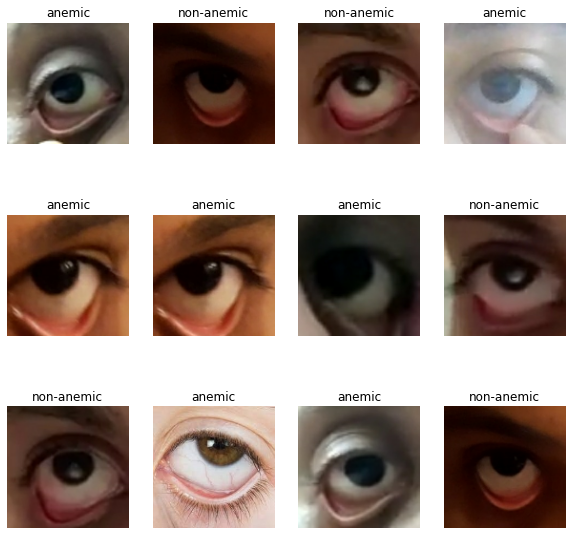

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

12

In [ ]:
train_size = 0.6
len(dataset)*train_size

7.199999999999999

In [ ]:
train_ds = dataset.take(7)
len(train_ds)

7

In [ ]:
test_ds = dataset.stest_ds = dataset.skip(7)
len(test_ds)

5

In [ ]:
val_size=0.1
len(dataset)*val_size

1.2000000000000002

Split Trai, Test , Validation Set
After trying several splits this one worked.
Our datset is small

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print('train_ds', len(train_ds))
print('test_ds', len(test_ds))
print('val_ds', len(val_ds))


train_ds 7
test_ds 3
val_ds 2


Optimizing Pipeline

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Function:Resize layer

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE_1, IMAGE_SIZE_1),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Augmentation function

In [ ]:
data_augmentation = tf.keras.Sequential([
  #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.4),
])

Apply to training set

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size= tf.data.experimental.AUTOTUNE)

Model with parameter ste 1 . Augmentation layer outside

In [ ]:
input_shape = (BATCH_SIZE_1, IMAGE_SIZE_1, IMAGE_SIZE_1, CHANNELS)
n_classes = 2

model_1_aug_in = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_1_aug_in.build(input_shape=input_shape)

In [ ]:
model_1_aug_in.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 30, 30, 64)         0         
 2D)                                                  

In [ ]:
model_1_aug_in.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model_1_aug_in.fit(
    train_ds,
    batch_size=BATCH_SIZE_1,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
7/7 [==============================] - 3s 331ms/step - loss: 0.6900 - accuracy: 0.5146 - val_loss: 0.6682 - val_accuracy: 0.5000
Epoch 2/50
7/7 [==============================] - 2s 294ms/step - loss: 0.6013 - accuracy: 0.6893 - val_loss: 0.5435 - val_accuracy: 0.8125
Epoch 3/50
7/7 [==============================] - 2s 298ms/step - loss: 0.4561 - accuracy: 0.7864 - val_loss: 0.5275 - val_accuracy: 0.8125
Epoch 4/50
7/7 [==============================] - 2s 298ms/step - loss: 0.6261 - accuracy: 0.7573 - val_loss: 0.6585 - val_accuracy: 0.5312
Epoch 5/50
7/7 [==============================] - 2s 294ms/step - loss: 0.4610 - accuracy: 0.7767 - val_loss: 0.4909 - val_accuracy: 0.8125
Epoch 6/50
7/7 [==============================] - 2s 295ms/step - loss: 0.4727 - accuracy: 0.8252 - val_loss: 0.3657 - val_accuracy: 0.8438
Epoch 7/50
7/7 [==============================] - 2s 296ms/step - loss: 0.3267 - accuracy: 0.8544 - val_loss: 0.2939 - val_accuracy: 0.8750
Epoch 8/50
7/7 [====

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Accuracy evaluation


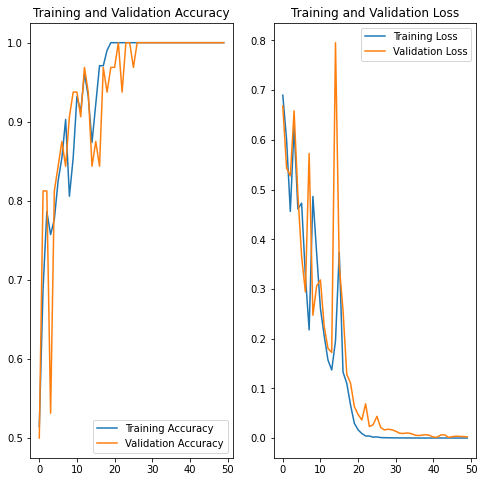

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Visualize Prediction

first image to predict
actual label: anemic
predicted label: anemic


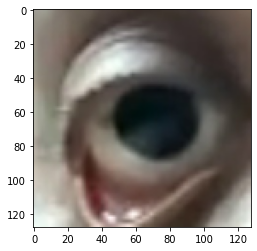

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model_1_aug_in.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    #decode_predictions() #Top 5 classes

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Explain Prediction

In [ ]:
!pip install lime




     |████████████████████████████████| 275 kB 13.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=767b970828d575a92da59a0641318a90ef58aa90280b539d7928a1a1fc3d17ed
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


Save the model

In [ ]:
model_1_aug_in.save("../anemia3.h5")

In [ ]:
new_model = tf.keras.models.load_model('/anemia3.h5')

In [ ]:
new_model.predict

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x7f71c139d8d0>>

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)


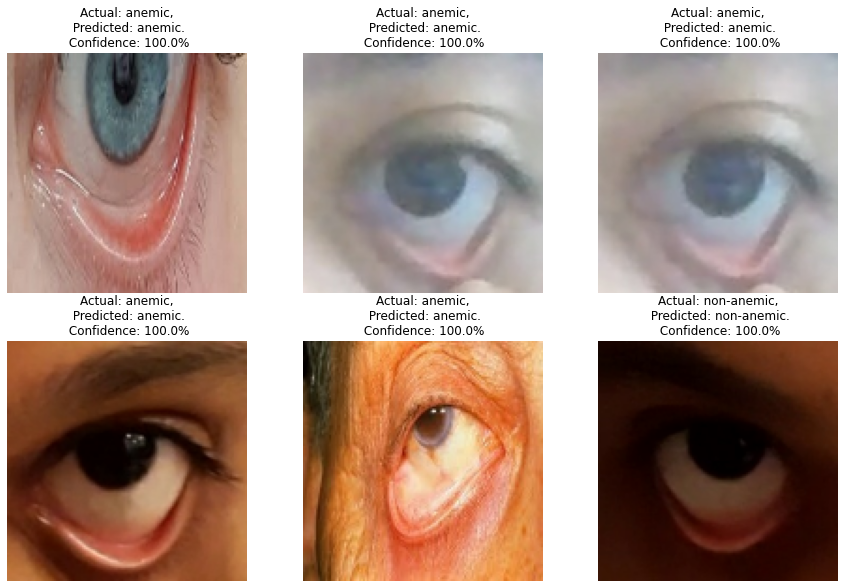

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
image = images[3]
explanation = explainer.explain_instance(
         image.numpy().astype("uint8"),
         new_model.predict
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


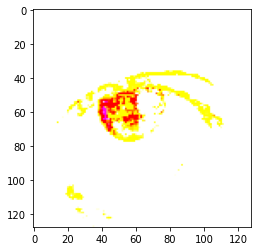

In [ ]:
plt.imshow(images[3])


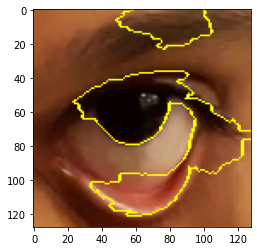

In [ ]:
image, mask = explanation.get_image_and_mask(
         new_model.predict(
        image.numpy().reshape((1,IMAGE_SIZE_1,IMAGE_SIZE_1,3))
         ).argmax(axis=1)[0],
         positive_only=True,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


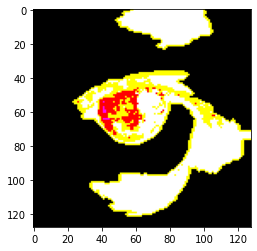

In [ ]:
temp, mask = explanation.get_image_and_mask(new_model.predict(image.reshape((1,IMAGE_SIZE_1,IMAGE_SIZE_1,3))).argmax(axis=1)[0], positive_only=True, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))